<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# 1. Remove any non residential properties

In [431]:
# load the data
house = pd.read_csv('./housing.csv', index_col='Id')
house.shape

(1460, 80)

In [432]:
# identify property types in dataset
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [433]:
# create residential dataset
residential = house[house.MSZoning.isin(['RL','RM','FV','RH'])]

# check number of commercial properties removed
print(len(house) - len(residential), 'non-residential records removed.')

10 non-residential records removed.


#  
#  
# 2. Define the datasets

In [434]:
# residential.info()

In [435]:
# define categorical feature dataframe by datatype for now
cat = residential.select_dtypes(include=['object']).copy()

In [436]:
# define continuous feature dataframe by datatype for now
con = residential.select_dtypes(include=['float64','int64']).copy()
con.drop('SalePrice', axis=1, inplace=True)

In [437]:
# define target
target = residential.SalePrice
print('Average Sale Price =',round(target.mean()))

Average Sale Price = 181655


In [438]:
# check shapes of datasets
cat.shape, con.shape, target.shape

((1450, 43), (1450, 36), (1450,))

#  
#  
# 3. Investigate YrSold Feature - Index

In [439]:
# This feature is being used to split the train and test datasets.  This will likely
# cause problems given the test dataset will only contain 2010 and the training 
# dataset will exclude 2010.

# We cant exclude it though as we need this feature to split the train and test 
# datasets. We will retain it as a separate series used for indexing only

In [440]:
# check YrSold correlation with target.  There is no linear correlation present.
con[['YrSold']].corrwith(target)

YrSold   -0.025391
dtype: float64

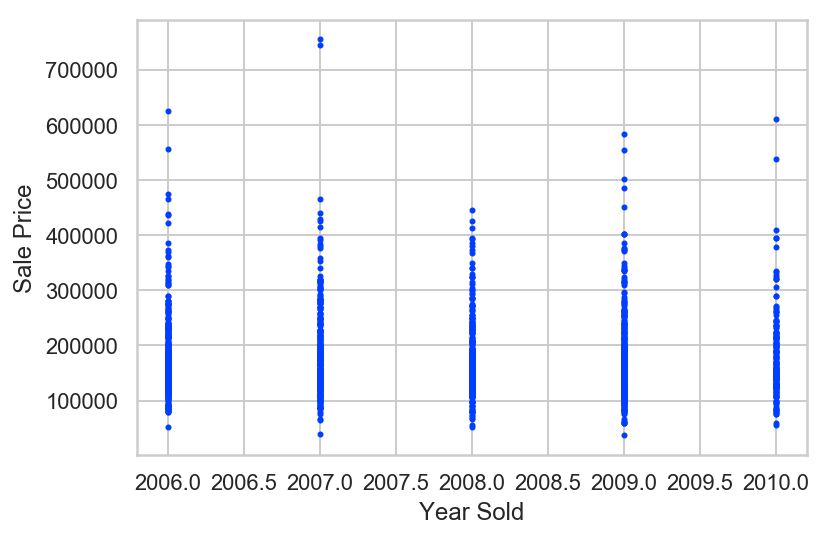

In [441]:
# check YrSold values against target.  It confrms there is no linear correlation.
plt.scatter(con.YrSold, target, s=4)
plt.xlabel('Year Sold')
plt.ylabel('Sale Price')
plt.show()

In [442]:
# define YrSold to be used for train/test splitting only
YrSold = con.YrSold
con.drop('YrSold', axis=1, inplace=True)

In [443]:
#define train indexes
train_index = YrSold.isin([2006,2007,2008,2009])

# define test indexes
test_index = YrSold == 2010

#  
#  
# 4. Investigate Target data

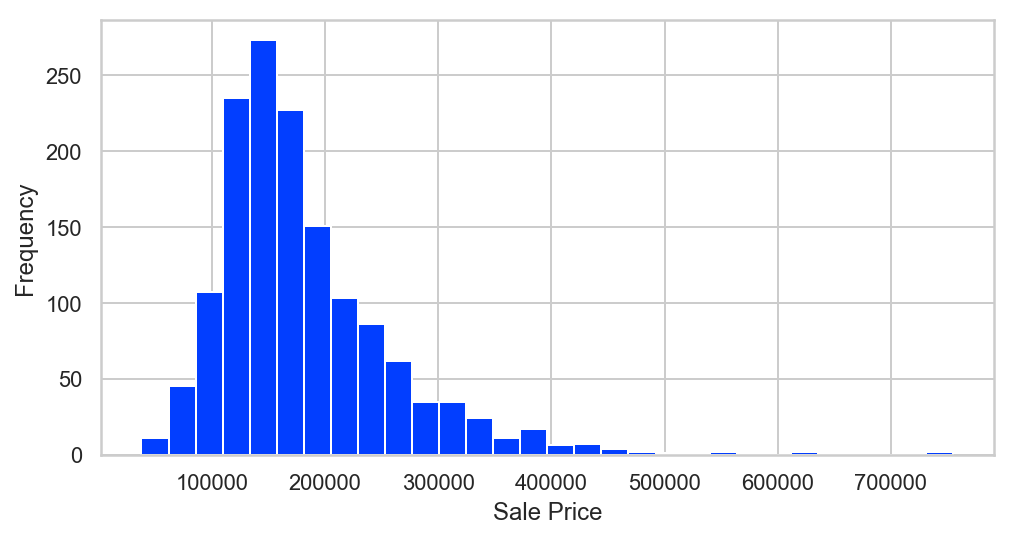

In [444]:
# check distribution of target data
target.plot(kind='hist', bins=30, figsize=(8,4))
plt.xlabel('Sale Price')
plt.show()

In [445]:
# target appears to have a log normal distribution so we should transform it.
log_target = target.transform(func='log')
log_target = log_target.rename('SalePrice_log')

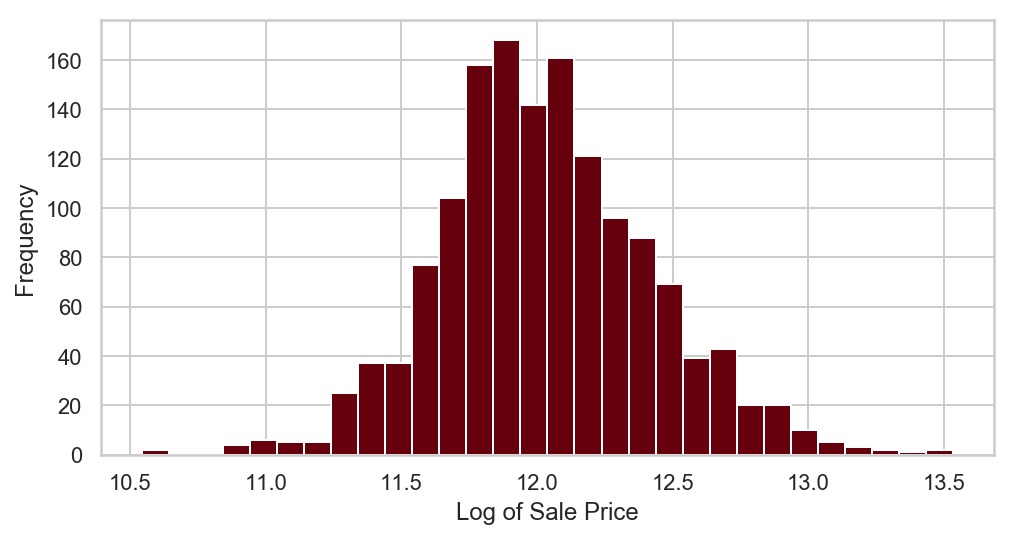

In [446]:
# check distribution of target
log_target.plot(kind='hist', bins=30,  figsize=(8,4), colormap='Reds_r')
plt.xlabel('Log of Sale Price')
plt.show()

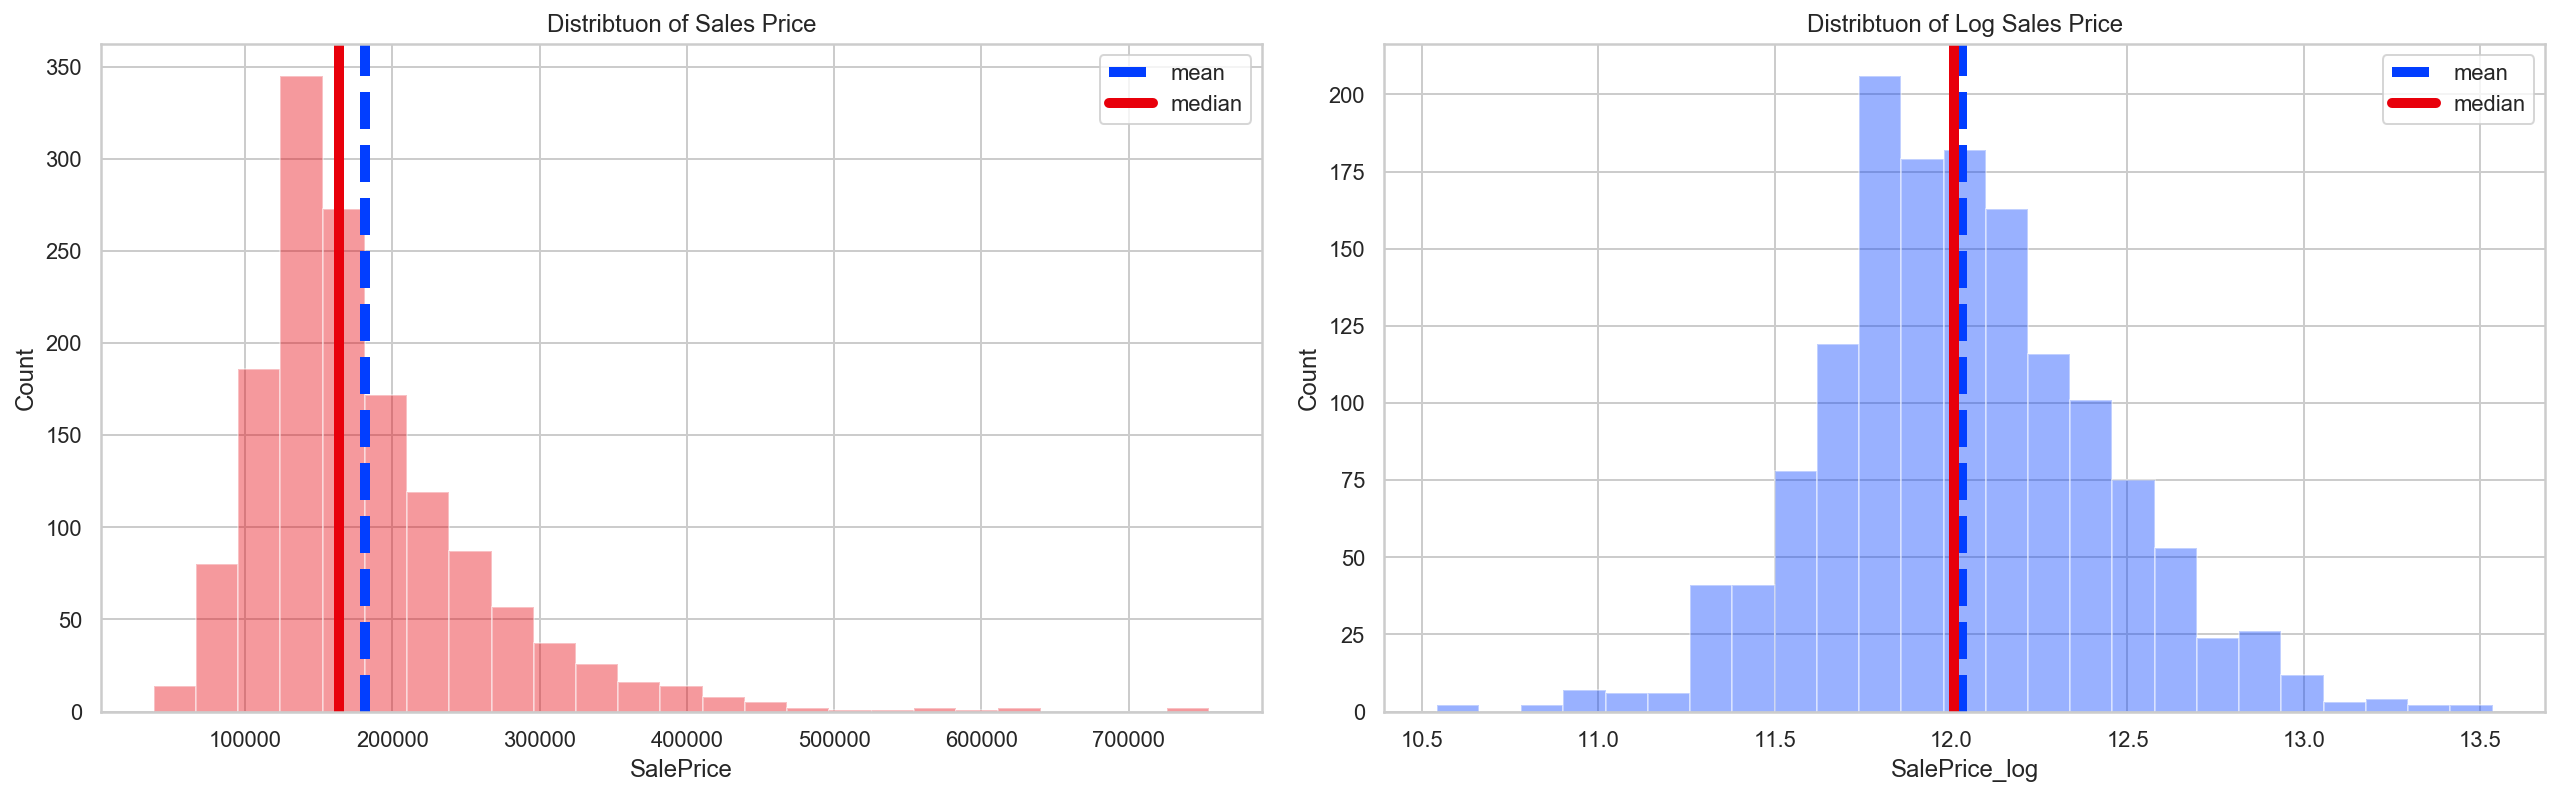

In [447]:
sns.set(style="whitegrid", palette="bright", color_codes=True) 
fig, axes = plt.subplots(1,2, figsize=(18,6), sharex=False)
#fig.suptitle("Distribution of Sale Price", fontsize=20)


d1 = sns.distplot(target, bins=25, ax=axes[0], kde=False, color ='r')
d2 = sns.distplot(log_target, bins=25, ax=axes[1], kde=False, color='b')

d1.axvline(np.mean(target), color = 'b', lw=5, ls='dashed', label='mean')
d1.axvline(np.median(target), color = 'r', lw=5, label='median')
d2.axvline(np.mean(log_target), color = 'b', lw=5, ls='dashed', label='mean')
d2.axvline(np.median(log_target), color = 'r', lw=5, label='median')

d1.legend()
d2.legend()

d1.set(title='Distribtuon of Sales Price', ylabel='Count')
d2.set(title='Distribtuon of Log Sales Price', ylabel='Count')

plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [448]:
# define target train and test datasets
y_train = log_target[train_index]
y_test = log_target[test_index]

#  
#  
# 5. Address the nulls in the Categorical Features Dataframe

In [449]:
# identify features with null values
cat.isnull().sum().sort_values(ascending= False).head(17)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
GarageCond        79
GarageQual        79
GarageFinish      79
GarageType        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
Electrical         1
Condition2         0
dtype: int64

In [450]:
# note that in the data dictionary the garage/basement/pool/miscfeature/fence/
# fireplace/alley features all have null defined as a pre-existing category.
# So we can change these nulls to 'No'.

cat.update(cat[['GarageCond','GarageQual','GarageFinish','GarageType','BsmtFinType2',
               'BsmtExposure','BsmtFinType1','BsmtQual','BsmtCond',
               'PoolQC','MiscFeature','Fence','FireplaceQu','Alley']].fillna('No'))

In [451]:
# check MasVnrType values
cat.MasVnrType.value_counts(dropna=False).sort_index() 

BrkCmn      15
BrkFace    445
None       854
Stone      128
NaN          8
Name: MasVnrType, dtype: int64

In [452]:
# check that MasVnrArea is also null where MasVnrType is null.
residential[residential.MasVnrType.isnull()][['MasVnrType','MasVnrArea']].isnull().sum()

MasVnrType    8
MasVnrArea    8
dtype: int64

In [453]:
# change MasVnrType null to None
cat.MasVnrType.fillna(value='None', inplace=True)

In [454]:
# check Electrical values
cat.Electrical.value_counts(dropna=False).sort_index() 

FuseA      90
FuseF      27
FuseP       3
Mix         1
SBrkr    1328
NaN         1
Name: Electrical, dtype: int64

In [455]:
# check value of property where Electrical is null
residential[residential.Electrical.isnull()]['SalePrice']

Id
1380    167500
Name: SalePrice, dtype: int64

In [456]:
# based on sale price it appears reasonable to assume that this property 
# has access to Electricity. We can change the null to SBrkr.
cat.Electrical.fillna(value='SBrkr', inplace=True)

In [457]:
# change features to type category
cat = cat.astype('category')

#  
#  
# 6. Address the nulls in the Continuous Features Dataframe

In [458]:
# identify features with null values
con.isnull().sum().sort_values(ascending= False).head(4)

LotFrontage    259
GarageYrBlt     79
MasVnrArea       8
MoSold           0
dtype: int64

In [459]:
# investigate MasVnrArea
# from investigation into MasVnrType above we have assumed that a null value 
# indicates None MasVnrType and 0 MasVnrArea
con.MasVnrArea.value_counts(dropna=False).sort_values(ascending=False).head(4)

 0.0      851
 72.0       8
 180.0      8
NaN         8
Name: MasVnrArea, dtype: int64

In [460]:
# change MasVnrArea nulls to 0
con.MasVnrArea.fillna(value=0, inplace=True) 
con.MasVnrArea = con.MasVnrArea.astype('int')

In [461]:
# investigate LotFrontage
con.LotFrontage.value_counts(dropna=False).sort_values(ascending=False).head()

NaN      259
 60.0    139
 70.0     70
 80.0     69
 50.0     55
Name: LotFrontage, dtype: int64

In [462]:
# check mean value of property where LotFrontage is null
round(residential[residential.LotFrontage.isnull()]['SalePrice'].mean())

181620

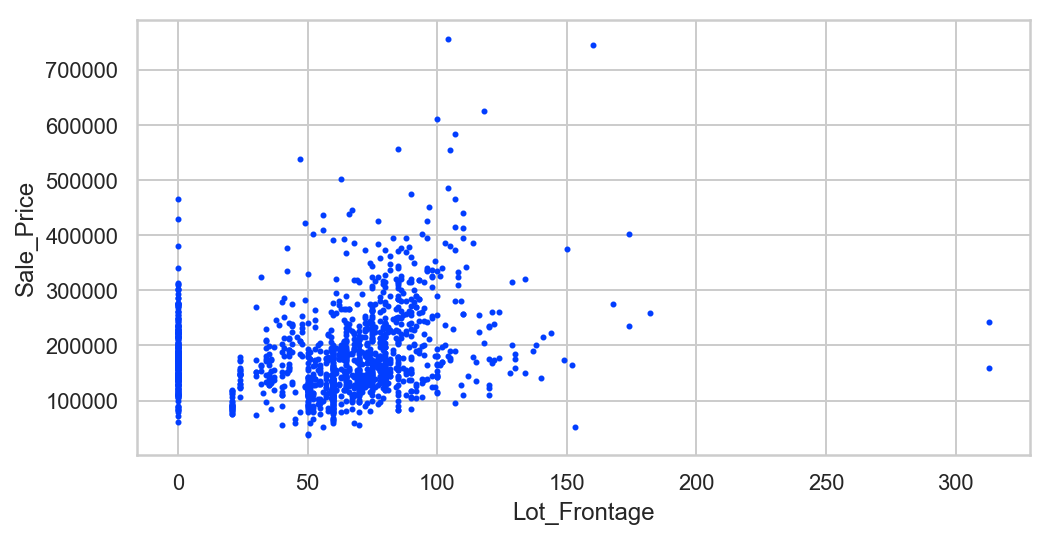

In [463]:
# sale price where lot frontage is null is similar to overall average
# assume LotFrontage of null means there is 0 lot frontage.
# change LotFrontage nulls to 0 for now and plot

plt.figure(figsize=(8,4))
plt.scatter(con.LotFrontage.fillna(0), target, s=4)
plt.xlabel('Lot_Frontage')
plt.ylabel('Sale_Price')
plt.show()

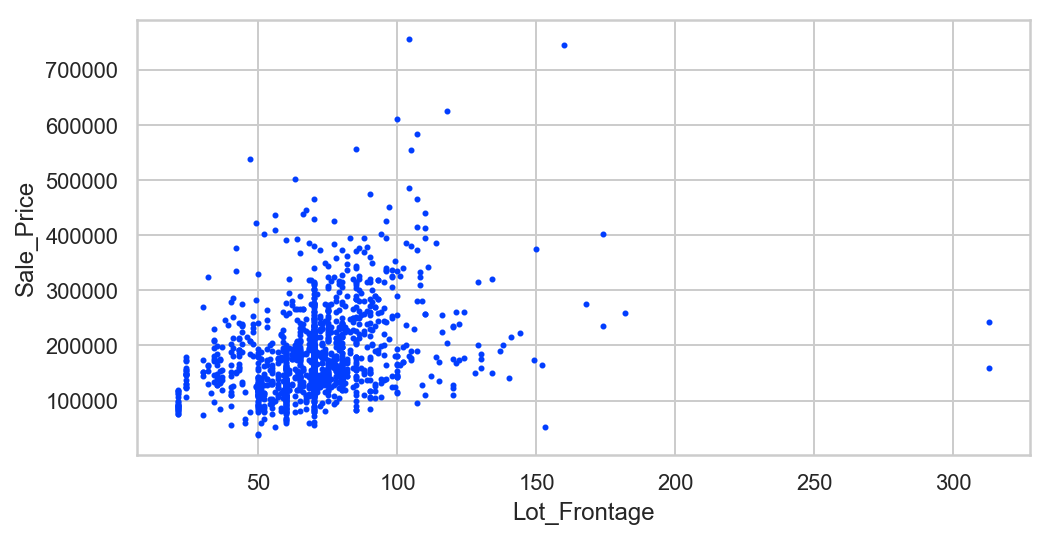

In [464]:
# change LotFrontage nulls to the median value and plot

plt.figure(figsize=(8,4))
plt.scatter(con.LotFrontage.fillna(con.LotFrontage.median()), target, s=4)
plt.xlabel('Lot_Frontage')
plt.ylabel('Sale_Price')
plt.show()

In [465]:
# change LotFrontage nulls to the median value
con.LotFrontage.fillna(con.LotFrontage.median(), inplace=True)
con.LotFrontage = con.LotFrontage.astype('int')

In [466]:
# investigate GarageYrBlt
con.GarageYrBlt.value_counts(dropna=False).sort_values(ascending=False).head(3)  

NaN        79
 2005.0    65
 2006.0    59
Name: GarageYrBlt, dtype: int64

In [467]:
# check mean value of property where GarageYrBlt is null
round(residential[residential.GarageYrBlt.isnull()]['SalePrice'].mean())

104415

In [468]:
# check mean value of property where GarageYrBlt is not null
round(residential[residential.GarageYrBlt.notnull()]['SalePrice'].mean())

186106

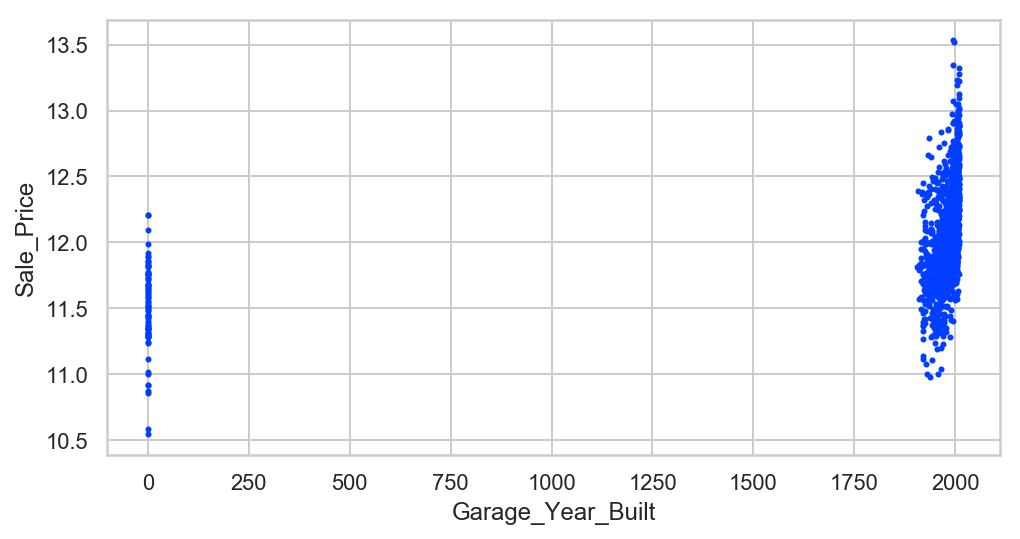

In [469]:
# we can assume if GarageYrBlt is null then the property has no garage
# change null values to 0 for now and plot

plt.figure(figsize=(8,4))
plt.scatter(con.GarageYrBlt.fillna(0), log_target, s=4)
plt.xlabel('Garage_Year_Built')
plt.ylabel('Sale_Price')
plt.show()

#con.GarageYrBlt.fillna(value=0, inplace=True)
#con.GarageYrBlt = con.GarageYrBlt.astype('int')

In [470]:
con[['GarageYrBlt']].fillna(0).corrwith(log_target)

GarageYrBlt    0.347238
dtype: float64

In [471]:
# this does not look like a good choice 
# what is the minimum GarageYrBlt
con.GarageYrBlt.min()

1906.0

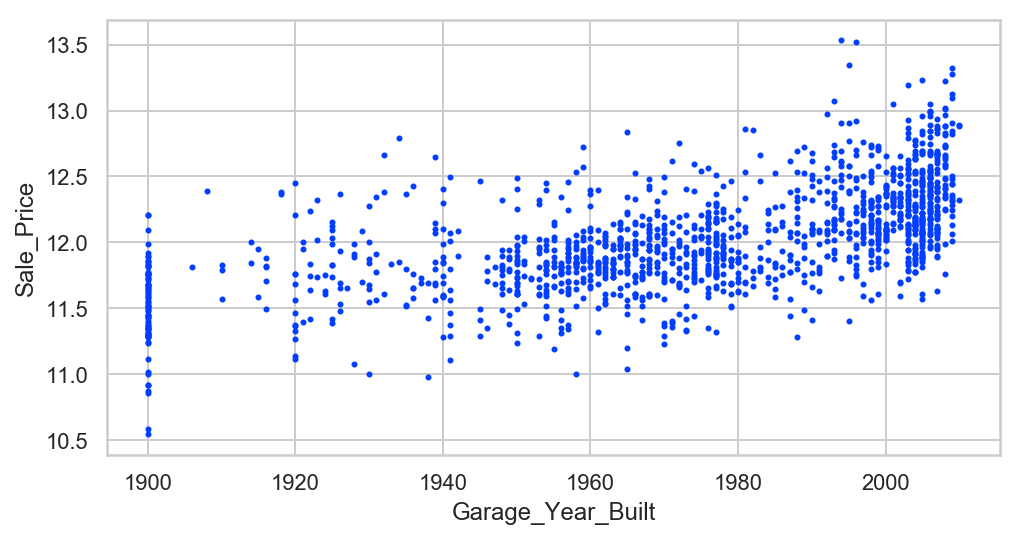

In [472]:
# change GarageYrBlt nulls to 1900 and plot

plt.figure(figsize=(8,4))
plt.scatter(con.GarageYrBlt.fillna(1900), log_target, s=4)
plt.xlabel('Garage_Year_Built')
plt.ylabel('Sale_Price')
plt.show()

In [473]:
# this looks a lot better
# change GarageYrBlt nulls to 1900
con.GarageYrBlt.fillna(1900, inplace=True)
con.GarageYrBlt = con.GarageYrBlt.astype('int')

In [474]:
con[['GarageYrBlt']].corrwith(log_target)

GarageYrBlt    0.595894
dtype: float64

#  
#  
# 7. Investigate Time Based Features

In [475]:
# investigate features which are time based
time_based_features = ['MoSold','GarageYrBlt','YearRemodAdd','YearBuilt']

In [476]:
tbf = pd.concat([con[time_based_features],log_target], axis=1)
tbf.head(2)

,MoSold,GarageYrBlt,YearRemodAdd,YearBuilt,SalePrice_log
Id,,,,,
1,2,2003,2003,2003,12.247694
2,5,1976,1976,1976,12.109011


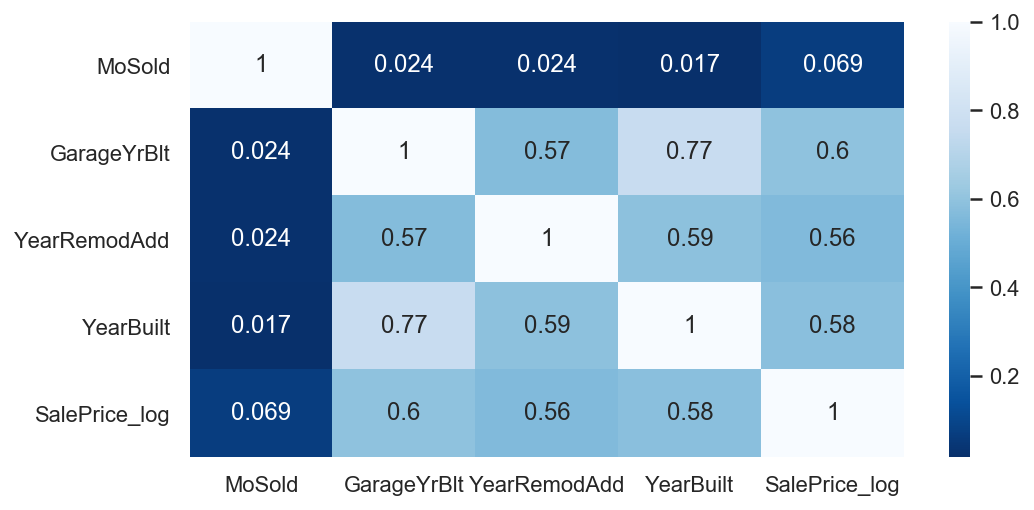

In [477]:
plt.figure(figsize=(8,4))
sns.heatmap(tbf.corr(), annot=True, cmap='Blues_r')

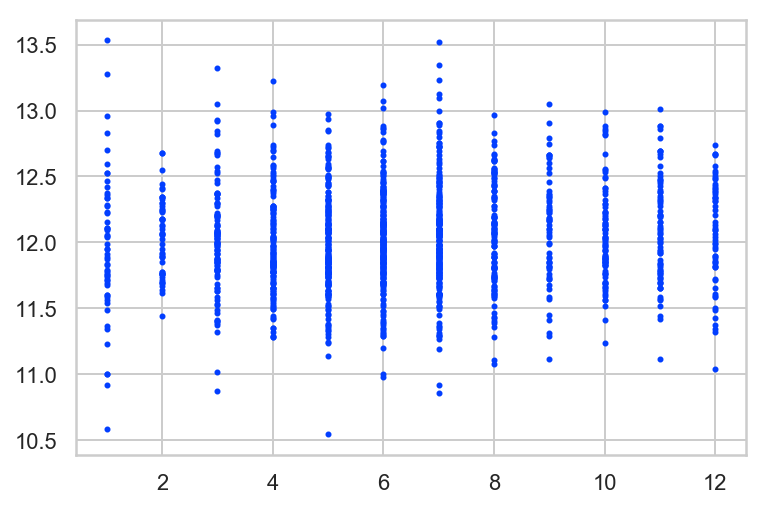

In [478]:
# investigate MoSold.
# if a linear relationship exists we can leave as a continuous feature
# if not there may be a seasonality component in which case we can make it categorical
plt.scatter(con.MoSold, log_target, s=4)
plt.show()

# has 0.07 correlation with log SalePrice. No evidence of linear relationship

In [479]:
# lets test it as a categorical feature
con['MoSold'] = con['MoSold'].astype('category')
df = pd.get_dummies(con[['MoSold']], prefix='MoSold',drop_first=True)
X_train = df[train_index]
X_test = df[test_index]

In [480]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores.mean())

0.011053302784464702
-0.01172882607183734
-0.01585438178707339


In [481]:
# these are very poor results as expected.  Lets remove it from the feature set.

In [482]:
con.drop('MoSold', axis=1, inplace=True) 

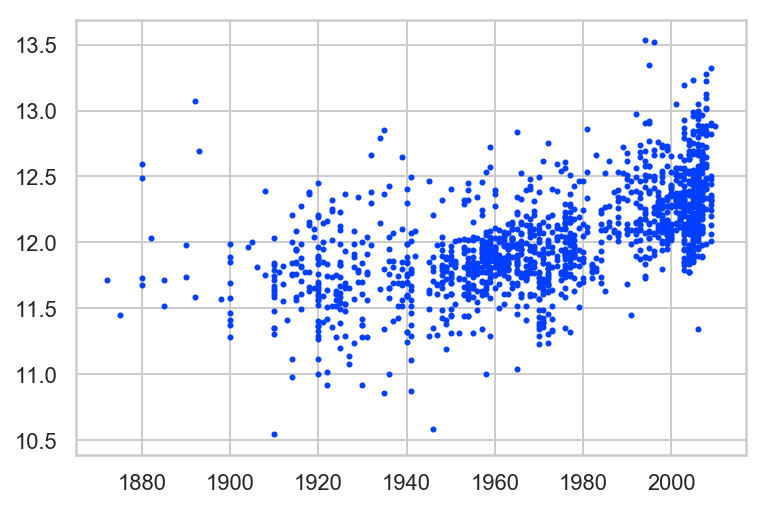

In [483]:
# investigate YearBuilt

plt.scatter(con.YearBuilt, log_target, s=4)
plt.show()
# has 0.58 correlation with log SalePrice. Keep as continuous feature

In [484]:
X_train = con[['YearBuilt']][train_index]
X_test = con[['YearBuilt']][test_index]

In [485]:
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores.mean())

0.33313650945922973
0.38502925449836956
0.3190476712239269


In [486]:
# lets see if converting the year to age gives better results
tbf['age'] = 2011 - con.YearBuilt

In [487]:
X_train = tbf[['age']][train_index]
X_test = tbf[['age']][test_index]

In [488]:
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores.mean())

0.3331365094592298
0.3850292544983693
0.31904767122392713


In [489]:
# no differene

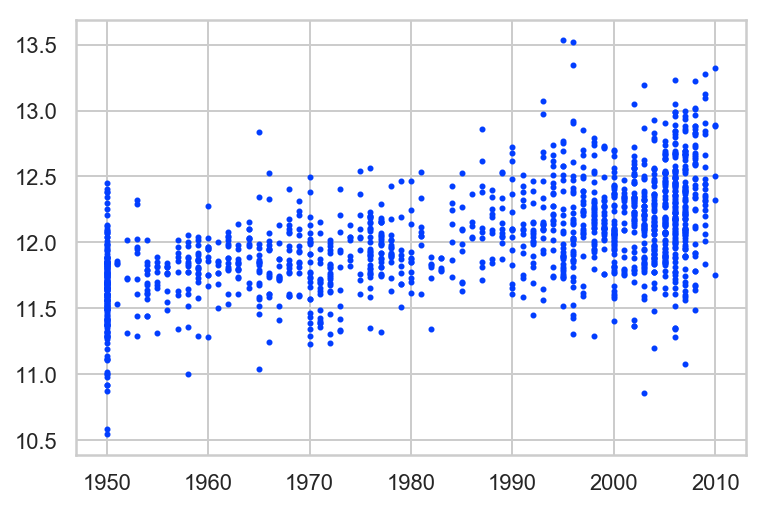

In [490]:
# investigate YearRemodAdd

plt.scatter(con.YearRemodAdd, log_target, s=4)
plt.show()
# has 0.56 correlation with log SalePrice. Keep as continuous feature

#  
#  
# 8. Identify Features in Continuous Dataframe which are Categorical

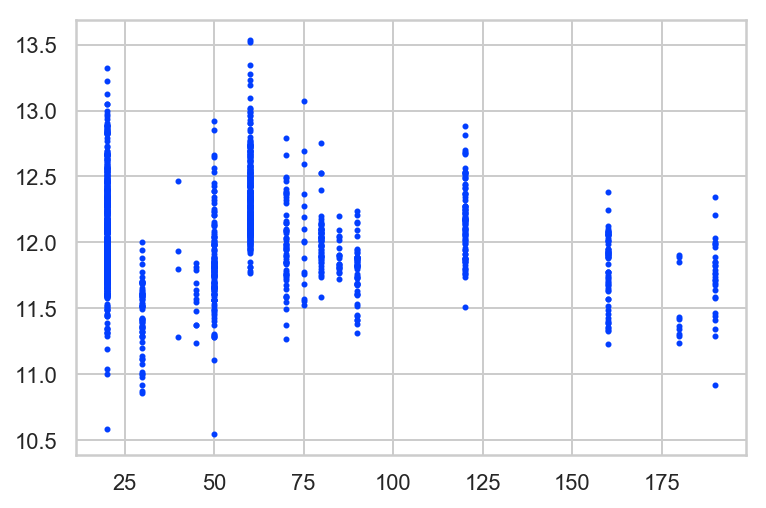

In [491]:
# identify featues in con dataframe which are categorical
# MSSubClass

plt.scatter(con['MSSubClass'], log_target, s=4)
plt.show()

In [492]:
# there is clearly no linear trend which suggest a categorical feature may be better.
# lets test it
X_train = con[['MSSubClass']][train_index]
X_test = con[['MSSubClass']][test_index]

In [493]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores.mean())

0.003722646373354732
0.022667683065989982
-0.005837830297954349


In [494]:
# this is a very low r squared.  Lets try it as a categorical feature

In [495]:
con['MSSubClass'] = con['MSSubClass'].astype('category')
df = pd.get_dummies(con[['MSSubClass']], prefix='MSSubClass',drop_first=True)
X_train = df[train_index]
X_test = df[test_index]

In [496]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores.mean())

0.3360874029123482
0.2950518411997206
0.3103040203262283


In [497]:
# these are much better results.  lets move MSSubClass to the cat dataframe
cat = pd.concat([cat,con['MSSubClass']], axis=1, sort=False)
con.drop('MSSubClass', axis=1, inplace=True) 
cat.MSSubClass = cat.MSSubClass.astype('category')

In [498]:
# now we have 2 clean dataframes
#      1. con - continuous features with all nulls addressed
#      2. cat - categorical features with all nulls addressed

In [499]:
con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 1 to 1460
Data columns (total 33 columns):
LotFrontage      1450 non-null int64
LotArea          1450 non-null int64
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrArea       1450 non-null int64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
BsmtUnfSF        1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
LowQualFinSF     1450 non-null int64
GrLivArea        1450 non-null int64
BsmtFullBath     1450 non-null int64
BsmtHalfBath     1450 non-null int64
FullBath         1450 non-null int64
HalfBath         1450 non-null int64
BedroomAbvGr     1450 non-null int64
KitchenAbvGr     1450 non-null int64
TotRmsAbvGrd     1450 non-null int64
Fireplaces       1450 non-null int64
GarageYrBlt      1450 non-null int64
Garag

In [500]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 1 to 1460
Data columns (total 44 columns):
MSZoning         1450 non-null category
Street           1450 non-null category
Alley            1450 non-null category
LotShape         1450 non-null category
LandContour      1450 non-null category
Utilities        1450 non-null category
LotConfig        1450 non-null category
LandSlope        1450 non-null category
Neighborhood     1450 non-null category
Condition1       1450 non-null category
Condition2       1450 non-null category
BldgType         1450 non-null category
HouseStyle       1450 non-null category
RoofStyle        1450 non-null category
RoofMatl         1450 non-null category
Exterior1st      1450 non-null category
Exterior2nd      1450 non-null category
MasVnrType       1450 non-null category
ExterQual        1450 non-null category
ExterCond        1450 non-null category
Foundation       1450 non-null category
BsmtQual         1450 non-null category
BsmtCond     

#  
#  
# 9. Remove Renovate-able Features

In [501]:
# select renovate-able features
renovate = ['RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
        'ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','Heating',
        'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
        'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']
renovate_con = ['OverallQual','OverallCond']

In [502]:
# store in cat_renov for question 2
cat_renov = cat[renovate]
con_renov = con[renovate_con]

In [503]:
# drop renovate-able features
cat.drop(renovate, axis=1, inplace=True) 
con.drop(renovate_con, axis=1, inplace=True) 

#  
#  
# 10. Model 1

In [504]:
# all features excluding MoSold
# one hot encoding
# standard scaling

In [590]:
# OHE
df = pd.get_dummies(cat, prefix=cat.columns, drop_first=True)

# split the categorical dataset
cat_train = df[train_index]
cat_test = df[test_index]

In [591]:
# standard scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# split the continuous dataset
con_train = con[train_index]
con_test = con[test_index]

con_train_ss = pd.DataFrame(ss.fit_transform(con_train), columns = con_train.columns, index = con_train.index)
con_test_ss = pd.DataFrame(ss.fit_transform(con_test), columns = con_test.columns, index = con_test.index)


In [592]:
# concatenate category and continuous datasets
X_train = pd.concat([cat_train, con_train_ss], axis=1)
X_test = pd.concat([cat_test, con_test_ss], axis=1)

In [593]:
# fit model_1
model = lr.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8674162835733807
-3.14297283788213e+23


In [594]:
# perform cross validation
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores)
print("Mean CV R2:", scores.mean())
print('Std CV R2:', scores.std())

[ 8.30184376e-01  8.61163578e-01 -2.14440965e+17 -4.94984340e+15
  8.55381475e-01 -9.00024639e+19 -8.72062745e+22  8.24415659e-01
 -2.15624677e+18 -4.68139829e+18]
Mean CV R2: -8.730333403567631e+21
Std CV R2: 2.6158660577536443e+22


In [595]:
### suggests over fitting

In [596]:
import statsmodels.api as sm
X = X_train.copy()
X['Intercept'] = 1
models = sm.OLS(y_train, X).fit()
print(models.rsquared)
#models.summary

0.8923119731505447


In [597]:
# statsmodels OLS gives a different Rsquared?

#  
#  
# 11. Model 2 - Test for Multi-colinearity

In [513]:
# lets test for multi-colinearity

In [514]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [515]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]

/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [516]:
vif['features'] = X_train.columns

In [517]:
remove = list(vif['features'][vif.VIF > 5.0].values)

In [518]:
# concern - both 'GrLivArea' & 'TotRmsAbvGrd' are in remove list ????

In [519]:
X_train2 = X_train.drop(remove, axis=1)
X_test2 = X_test.drop(remove, axis=1)

In [520]:
# fit model_2
model = lr.fit(X_train2, y_train)
print(model.score(X_train2, y_train))
print(model.score(X_test2, y_test))

0.7786870953433987
0.7244439518711823


In [521]:
# perform cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train2, y_train, cv=2)
print(scores)
print("Mean CV R2:", scores.mean())
print('Std CV R2:', scores.std())

[-7.49746625e+24 -8.61353897e+22]
Mean CV R2: -3.7918008196765953e+24
Std CV R2: 3.7056654299414974e+24


In [522]:
import statsmodels.api as sm
X = X_train2.copy()
X['Intercept'] = 1
models = sm.OLS(y_train, X).fit()
print(models.rsquared)
#print(models.summary())

0.7786870953433987


In [523]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train2.values,i) for i in range(X_train2.shape[1])]

In [524]:
vif['features'] = X_train2.columns

In [525]:
#vif.VIF.sort_values()
# no multi-colinearity present

#  
#  
# 12. Model 3 - Regularization

In [246]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV


# find optimal alpha for ridge model

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print(optimal_ridge.alpha_)

10.116379797662075


In [248]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))
print(optimal_ridge.score(X_train,y_train))
print(optimal_ridge.score(X_test,y_test))

[0.89779396 0.89923505 0.88743745 0.79418803 0.86361532 0.88704087
 0.8733707  0.842437   0.51686998 0.85776017]
0.831974853856862
0.8832928558168959
0.8979521913077709


In [228]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge2 = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge2.fit(X_train2, y_train)

print(optimal_ridge2.alpha_)

6.010276782070384


In [245]:
ridge = Ridge(alpha=optimal_ridge2.alpha_)

ridge_scores = cross_val_score(ridge, X_train2, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))


[0.75868671 0.77836186 0.80884849 0.6884039  0.77669651 0.73774149
 0.74176307 0.73185087 0.57656603 0.74472861]
0.7343647529148993


NotFittedError: This Ridge instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that "vanilla" regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

In [598]:
#optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
#optimal_lasso.fit(X_train, y_train)

#print(optimal_lasso.alpha_)

lassotest = LassoCV(n_alphas=1000,cv=10).fit(X_train, y_train)
print(lassotest.alpha_)

0.0007717058479380043


In [599]:
lasso_model = Lasso(alpha=lassotest.alpha_)
lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv=10)
print(lasso_scores)
print(np.mean(lasso_scores))

[0.89618457 0.9019269  0.89173719 0.80210685 0.86338921 0.88930887
 0.87308079 0.83990491 0.48341257 0.85584757]
0.8296899428964787


In [600]:
lasso_model.fit(X_train, y_train)
print(lasso_model.score(X_train,y_train))
print(lasso_model.score(X_test,y_test))

0.8770756621061784
0.9020212298574204


In [601]:
print('Percent variables zeroed out:', np.sum((lasso_model.coef_ == 0))/float(X_train.shape[1]))

Percent variables zeroed out: 0.5241379310344828


In [602]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso_model.coef_,
                            'abs_coef':np.abs(lasso_model.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [603]:
print(len(lasso_coefs[lasso_coefs.coef == 0]))
print(np.sum((lasso_model.coef_ == 0)))

76
76


In [604]:
len(lasso_coefs[lasso_coefs.coef != 0])

69

In [605]:
len(lasso_coefs)

145

In [606]:
X_train.shape[1]

145

In [607]:
predictions = pd.DataFrame()
pred = lasso_model.predict(X_test)
predictions['predictions'] = pred

In [611]:
y_test_ = y_test.transform(func='exp')
y_test_.rename('SalePrice', inplace=True)

Id
17      149000.0
25      154000.0
27      134800.0
28      306000.0
34      165500.0
39      109000.0
46      319900.0
53      110000.0
64      140000.0
67      180000.0
69       80000.0
74      144900.0
75      107400.0
79      136500.0
99       83000.0
100     128950.0
101     205000.0
102     178000.0
104     198900.0
110     190000.0
112     180000.0
119     320000.0
141     115000.0
143     166000.0
148     222500.0
158     269500.0
159     254900.0
163     220000.0
172     215000.0
201     140000.0
          ...   
1243    170000.0
1248    169900.0
1251    244000.0
1268    378500.0
1271    260000.0
1284    139000.0
1285    169000.0
1287    143000.0
1291    180500.0
1300    154000.0
1311    335000.0
1314    333168.0
1323    190000.0
1354    410000.0
1358    149900.0
1359    177500.0
1366    216000.0
1370    232000.0
1381     58500.0
1386    125500.0
1397    160000.0
1409    125500.0
1417    122500.0
1422    127500.0
1429    119000.0
1439    149700.0
1447    157900.0
1457    210

In [612]:

predictions_ = predictions.predictions.transform(func='exp')

In [615]:
lasso_resid = y_test_ - predictions_

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


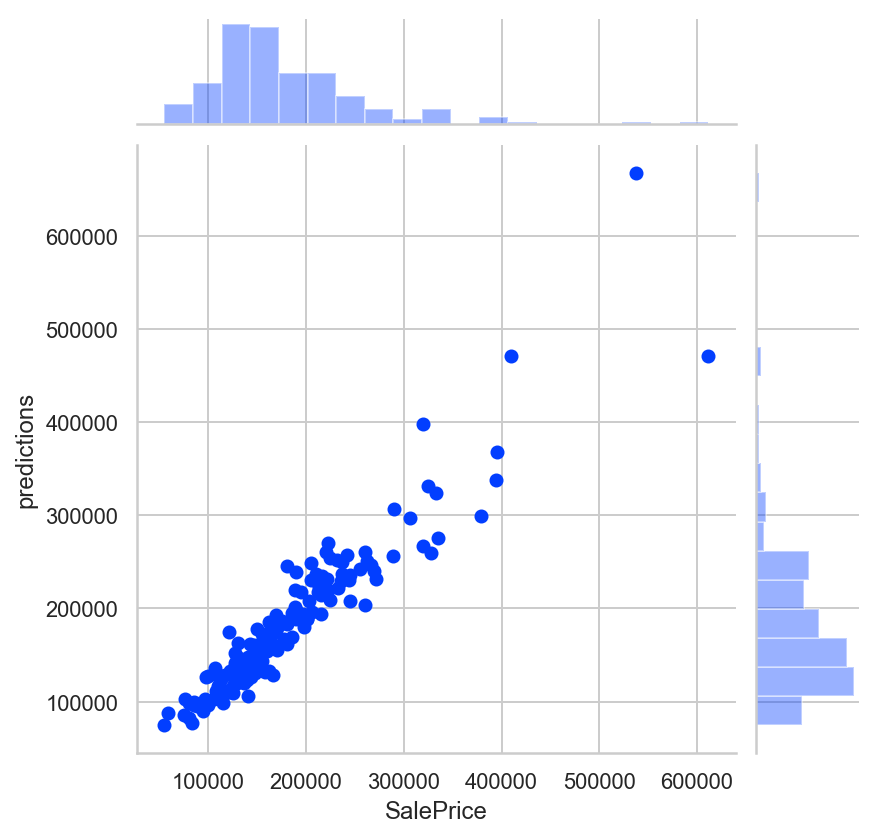

In [616]:
sns.jointplot(y_test_, predictions_)

In [617]:
lasso_resid = y_test_ - predictions_

In [618]:
lasso_resid.mean()

-8581.311342821815

In [619]:
8581/179167

0.04789386438350812

In [411]:
y_test_.mean()

179167.0

In [269]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.003670892799371302
0.0925


In [271]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores))
en = enet.fit(X_train, y_train)
print(en.score(X_train,y_train))
print(en.score(X_test,y_test))

[0.89882966 0.9019104  0.89031308 0.7983717  0.8627749  0.89075942
 0.87409273 0.84257477 0.51328666 0.85802042]
0.8330933740965267
0.8814547916219216
0.9009210326618335


In [2313]:
pvals = models.pvalues

In [2331]:
vals = pvals.values
ind = pvals.index

In [2332]:
d = pd.DataFrame(vals, index=ind)

In [ ]:
# Question 2

In [620]:
# remove lasso zeroed out features from dataset
remove = list(lasso_coefs.variable[lasso_coefs.coef == 0])

X_train_2 = X_train.drop(remove, axis=1)
X_test_2 = X_test.drop(remove, axis=1)

In [621]:
# fit model_1
lasso_model.fit(X_train_2, y_train)
print(lasso_model.score(X_train_2,y_train))
print(lasso_model.score(X_test_2,y_test))

0.8770754762797703
0.9020223047019342


In [423]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(lasso_model, X_train, y_train, cv=10)
print(scores)
print("Mean CV R2:", scores.mean())
print('Std CV R2:', scores.std())

[0.8965557  0.90236958 0.89534848 0.80278141 0.86398927 0.889594
 0.87308991 0.84004802 0.48739896 0.85588273]
Mean CV R2: 0.8307058046697209
Std CV R2: 0.11806062837615293


In [424]:
# add fixed features
cat_renov.head(2)

,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,...,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
Id,,,,,,,,,,,,,,,,,,,,,
1,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,SBrkr,Gd,Typ,No,RFn,TA,TA,Y,No,No
2,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,ALQ,...,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,No,No


In [624]:
# OHE
df = pd.get_dummies(cat_renov, prefix=cat_renov.columns, drop_first=True)

# split the categorical dataset
cat_train = df[train_index]
cat_test = df[test_index]

In [625]:
#split the continuous dataset
con_train = con_renov[train_index]
con_test = con_renov[test_index]

In [626]:
# concatenate category and continuous datasets
X_train_3 = pd.concat([cat_train, con_train], axis=1)
X_test_3 = pd.concat([cat_test, con_test], axis=1)

In [555]:
# add to dataframe

In [627]:
X_train_4 = pd.concat([X_train_2, X_train_3], axis=1)
X_test_4 = pd.concat([X_test_2, X_test_3], axis=1)

In [641]:
#optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
#optimal_lasso.fit(X_train, y_train)

#print(optimal_lasso.alpha_)

lassotest = LassoCV(n_alphas=1000,cv=10).fit(X_train_4, y_train)
print(lassotest.alpha_)

0.0004405375464493396


In [639]:
lasso_model = Lasso(alpha=lassotest.alpha_)
lasso_scores = cross_val_score(lasso_model, X_train_4, y_train, cv=10)
print(lasso_scores)
print(np.mean(lasso_scores))

[0.92463936 0.94087425 0.92720197 0.82872647 0.90103164 0.88034174
 0.89624882 0.90741267 0.58907162 0.87734289]
0.8672891407260295


In [640]:
lasso_model.fit(X_train_4, y_train)
print(lasso_model.score(X_train_4,y_train))
print(lasso_model.score(X_test_4,y_test))

0.9190422132243888
0.9171199914601097


In [631]:
predictions = pd.DataFrame()
pred = lasso_model.predict(X_test_4)
predictions['predictions'] = pred

In [647]:
pred_exp = pred

NameError: name 'e' is not defined

In [632]:
y_test_ = y_test.transform(func='exp')
y_test_.rename('SalePrice', inplace=True)
predictions_ = predictions.predictions.transform(func='exp')

In [633]:
lasso_resid = y_test_ - predictions_

In [634]:
lasso_resid.mean()

-8072.442631210383

In [589]:
y_test_.mean() - predictions_.mean()

-781.8113214202458

In [585]:
y_test_.mean()

179167.0

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


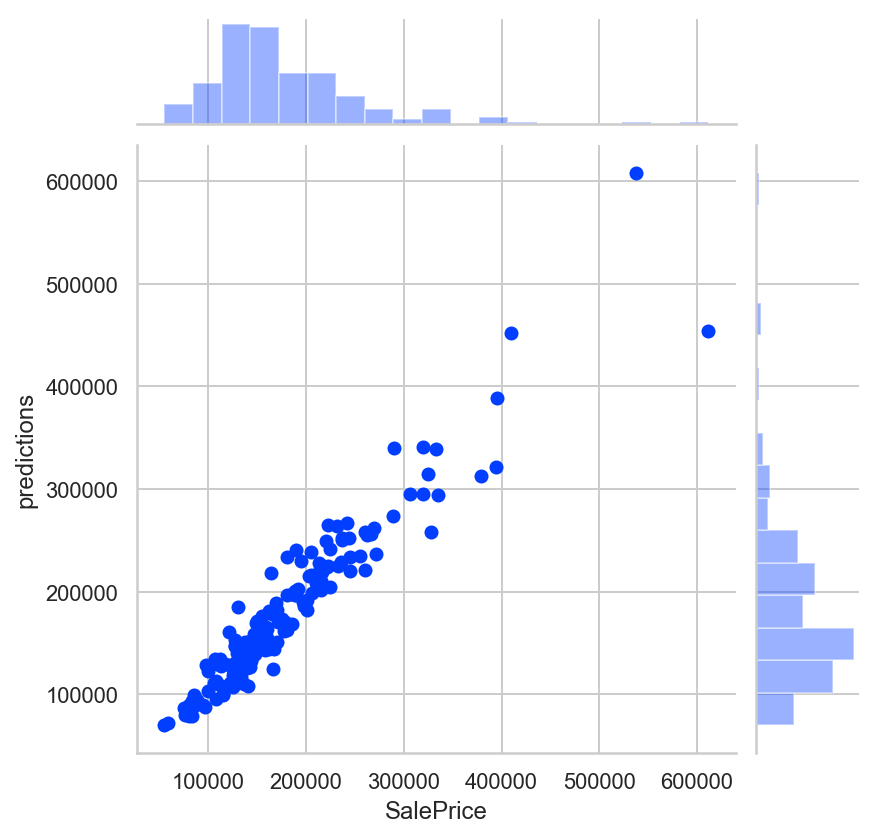

In [635]:
sns.jointplot(y_test_, predictions_)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [4]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: